<a href="https://colab.research.google.com/github/yeho/scikit-learn-AI/blob/master/vision%20por%20computadora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import json
import os
import requests

import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
from torchvision import transforms
from torch.nn import Sequential

# Function to load image and convert to grayscale with error handling
def load_image_and_grayscale(image_path):
    """
    Loads an image from the specified path and converts it to grayscale.
    Handles cases where the image file does not exist.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen '{image_path}'. Asegúrate de que el archivo existe.")
        return None, None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

# Function to apply Canny edge detection
def apply_canny_edge_detection(gray_image, low_threshold=100, high_threshold=200):
    """
    Applies Canny edge detection to a grayscale image.
    """
    if gray_image is None:
        return None
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)
    return edges

# Function to apply K-Means segmentation
def apply_kmeans_segmentation(original_image, n_clusters=3, max_iter=10, epsilon=1.0):
    """
    Applies K-Means clustering for image segmentation.

    Parameters:
    - original_image: The image to segment.
    - n_clusters: The number of clusters (K) for K-Means.
    - max_iter: Maximum number of iterations for K-Means.
    - epsilon: Required accuracy, final iteration will be terminated if criteria is met.
    """
    if original_image is None:
        return None
    # Reshape the image to a 2D array of pixels and 3 color channels
    Z = original_image.reshape((-1, 3))
    # Convert to float32 for K-Means processing
    Z = np.float32(Z)

    # Define criteria for K-Means algorithm
    # (type, max_iter, epsilon)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)

    # Apply K-Means clustering
    _, labels, centers = cv2.kmeans(Z, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to original image shape
    seg = centers[labels.flatten()].reshape(original_image.shape)
    return seg

# Function to initialize the ResNet18 model and transformation pipeline
def initialize_model_and_transform(model_name='resnet18', weights_version=models.ResNet18_Weights.IMAGENET1K_V1, resize_size=256, crop_size=224):
    """
    Initializes a pre-trained ResNet model and its transformation pipeline.

    Parameters:
    - model_name: Name of the model (e.g., 'resnet18').
    - weights_version: The weights to use for the model.
    - resize_size: Size to resize the image to.
    - crop_size: Size to center crop the image to.
    """
    if model_name == 'resnet18':
        model = models.resnet18(weights=weights_version)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    model.eval() # Set model to evaluation mode for inference

    transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor()
    ])
    return model, transform

# Function to process an image with the model, extract features, and get predictions
def process_image_with_model(image_path, model, transform, top_k_predictions=5):
    """
    Processes an image using the given model and transform, extracts visual embeddings
    and returns the top K predicted class probabilities and indices.
    """
    pil_image = Image.open(image_path)
    # Apply transform and add batch dimension (unsqueeze(0))
    x = transform(pil_image).unsqueeze(0)

    with torch.no_grad(): # Disable gradient calculation for inference
        out = model(x)

    # Create a feature extractor by removing the last classification layer
    feature_extractor = Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        features = feature_extractor(x)

    # Apply softmax to convert logits to probabilities and get top K predictions
    probs = torch.nn.functional.softmax(out, dim=1)
    top_k = torch.topk(probs, top_k_predictions)

    return features, probs, top_k, out # Return out as it's used for probs

# Function to download and load ImageNet labels
def load_imagenet_labels(labels_url, labels_file="imagenet-simple-labels.json"):
    """
    Downloads ImageNet labels if not already present and loads them from a JSON file.
    Includes error handling for download and file loading.
    """
    if not os.path.exists(labels_file):
        print(f"Descargando {labels_file}...")
        try:
            response = requests.get(labels_url)
            response.raise_for_status() # Raise an exception for HTTP errors
            with open(labels_file, "w") as f:
                json.dump(response.json(), f)
            print("Descarga completa.")
        except requests.exceptions.RequestException as e:
            print(f"Error al descargar las etiquetas: {e}")
            return None

    try:
        with open(labels_file, "r") as f:
            imagenet_labels = json.load(f)
        return imagenet_labels
    except Exception as e:
        print(f"Error al cargar las etiquetas desde '{labels_file}': {e}")
        return None

# Function to perform Otsu Thresholding
def perform_otsu_thresholding(gray_image):
    """
    Applies Otsu's binarization to a grayscale image.
    """
    if gray_image is None:
        return None
    # Otsu's thresholding automatically finds the optimal threshold
    ret, otsu = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu

# Function to plot original image and segmentations
def plot_image_and_segmentations(original_img, canny_edges, kmeans_seg, otsu_seg):
    """
    Displays the original image, Canny edges, K-Means segmentation, and Otsu thresholding.
    """
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(canny_edges, cmap='gray')
    plt.title('Canny Edges')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    # K-Means segmentation outputs float32, convert to uint8 for display
    plt.imshow(kmeans_seg.astype(np.uint8))
    plt.title('K-Means Segmentation')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(otsu_seg, cmap='gray')
    plt.title('Otsu Thresholding')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to plot top K probabilities
def plot_top_k_probabilities(class_labels, probabilities, k):
    """
    Generates a bar chart for the top K predicted class probabilities.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, probabilities, color='skyblue')
    plt.title(f'Top {k} ImageNet Class Probabilities')
    plt.xlabel('Class Label')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def run_classical_segmentation_pipeline(
    image_path,
    canny_low_threshold=100,
    canny_high_threshold=200,
    kmeans_n_clusters=3,
    kmeans_max_iter=10,
    kmeans_epsilon=1.0
):
    """
    Runs the classical image segmentation pipeline.
    """
    print(f"\n--- Starting Classical Segmentation for image: {image_path} ---")
    img, gray = load_image_and_grayscale(image_path)

    if img is None:
        print(f"Exiting segmentation as image '{image_path}' could not be loaded.")
        return

    edges = apply_canny_edge_detection(gray, canny_low_threshold, canny_high_threshold)
    seg = apply_kmeans_segmentation(img, kmeans_n_clusters, kmeans_max_iter, kmeans_epsilon)
    otsu = perform_otsu_thresholding(gray)

    print("\n--- Segmentation Visualizations ---")
    if edges is not None and seg is not None and otsu is not None:
        plot_image_and_segmentations(img, edges, seg, otsu)
    else:
        print("Skipping image and segmentation plots due to missing data.")
    print("Classical Segmentation complete.")
    return img, gray, edges, seg, otsu

def run_hierarchical_feature_extraction(
    image_path,
    model_name='resnet18',
    model_weights=models.ResNet18_Weights.IMAGENET1K_V1,
    resize_size=256,
    crop_size=224
):
    """
    Runs the hierarchical feature extraction using a pre-trained ResNet model.
    """
    print(f"\n--- Starting Hierarchical Feature Extraction for image: {image_path} ---")

    model, transform = initialize_model_and_transform(model_name, model_weights, resize_size, crop_size)

    # We only need features, so we'll adjust the process_image_with_model call
    # to ensure we get features as the primary output for this block.
    pil_image = Image.open(image_path)
    x = transform(pil_image).unsqueeze(0)
    feature_extractor = Sequential(*list(model.children())[:-1])
    with torch.no_grad():
        features = feature_extractor(x)

    print("\n--- Feature Extraction Results ---")
    print(f"Dimensiones del embedding visual: {features.shape}")
    print("Hierarchical Feature Extraction complete.")
    return features

def run_classification_pipeline(
    image_path,
    model_name='resnet18',
    model_weights=models.ResNet18_Weights.IMAGENET1K_V1,
    resize_size=256,
    crop_size=224,
    top_k_predictions=5,
    labels_url="https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json",
    labels_file="imagenet-simple-labels.json"
):
    """
    Runs the image classification pipeline.
    """
    print(f"\n--- Starting Classification for image: {image_path} ---")

    model, transform = initialize_model_and_transform(model_name, model_weights, resize_size, crop_size)
    features, probs, top_k, out = process_image_with_model(image_path, model, transform, top_k_predictions)

    print("\n--- Model Inference Results ---")
    print(f"Dimensiones del embedding visual (para referencia): {features.shape}")
    print(f"\nÍndices del Top {top_k_predictions}: {top_k.indices}")
    print(f"Valores de probabilidad del Top {top_k_predictions}: {top_k.values}")

    imagenet_labels = load_imagenet_labels(labels_url, labels_file)

    if imagenet_labels is not None:
        print(f"\n--- Top {top_k_predictions} Class Descriptions ---")
        class_labels = []
        probabilities = []
        for i, idx in enumerate(top_k.indices[0]):
            label = imagenet_labels[idx]
            probability = top_k.values[0][i].item()
            class_labels.append(label)
            probabilities.append(probability)
            print(f"{i+1}. {label} (Probabilidad: {probability:.4f})")

        print("\n--- Classification Visualization ---")
        plot_top_k_probabilities(class_labels, probabilities, top_k_predictions)
    else:
        print("No se pudieron cargar las etiquetas de ImageNet. No se mostrarán descripciones ni visualizaciones de probabilidad.")
    print("Classification complete.")

# The main execution block is removed, and will be replaced by calls in new cells.


--- Starting Classical Segmentation for image: moto2.jpg ---

--- Segmentation Visualizations ---


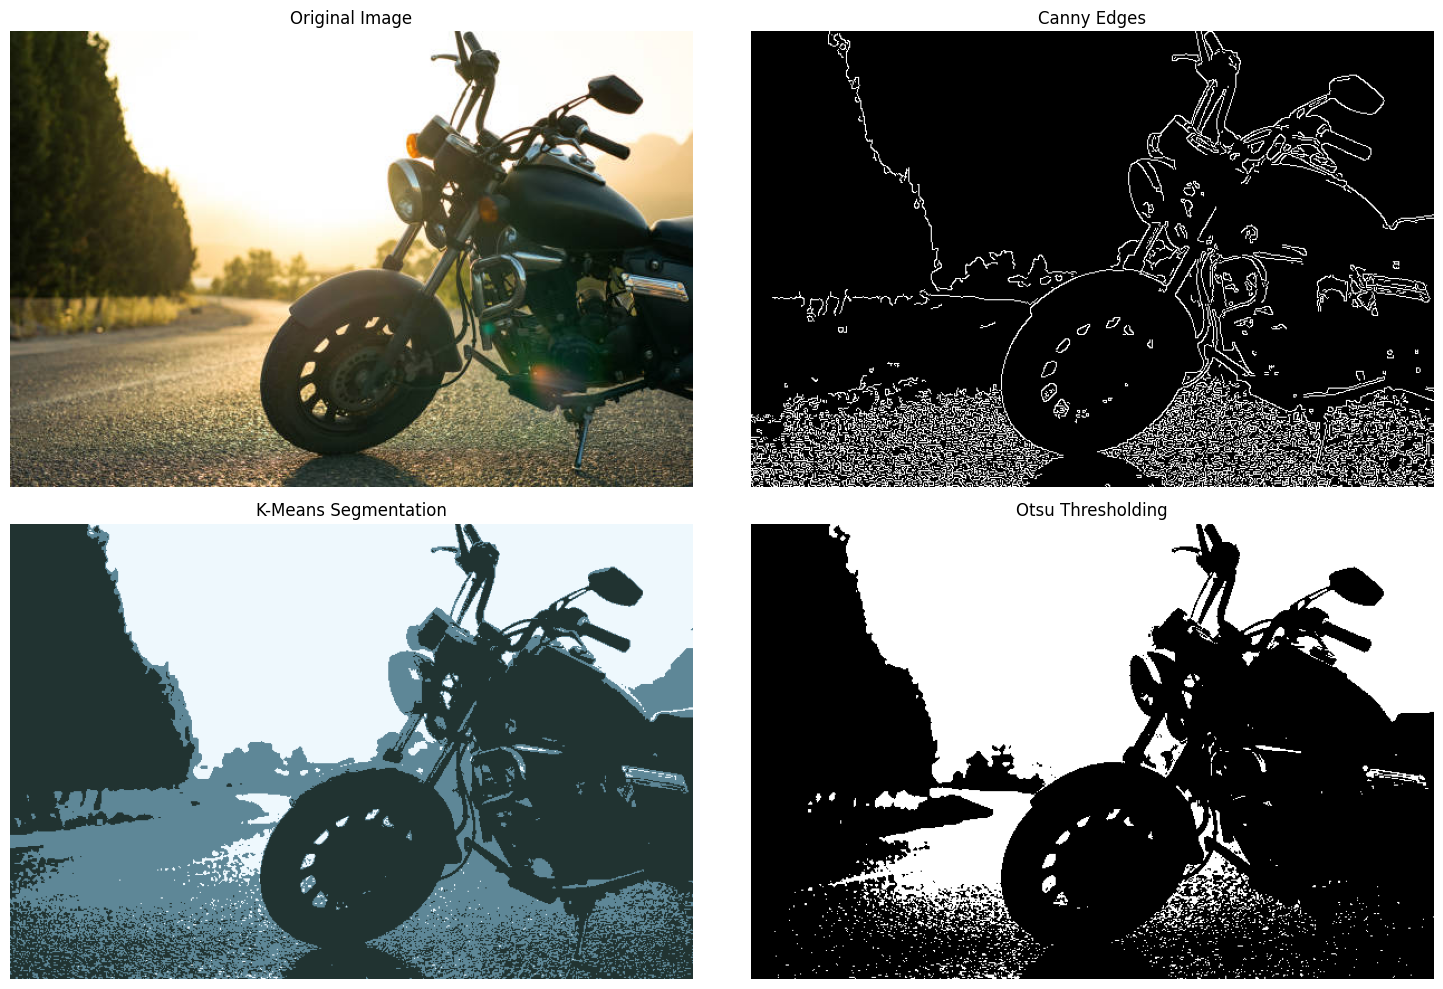

Classical Segmentation complete.


In [36]:
# Bloque de Segmentación Clásica
_ = run_classical_segmentation_pipeline(image_path="moto2.jpg")

In [37]:
# Bloque de Extracción Jerárquica de Características
_ = run_hierarchical_feature_extraction(image_path="moto2.jpg")


--- Starting Hierarchical Feature Extraction for image: moto2.jpg ---

--- Feature Extraction Results ---
Dimensiones del embedding visual: torch.Size([1, 512, 1, 1])
Hierarchical Feature Extraction complete.



--- Starting Classification for image: moto2.jpg ---

--- Model Inference Results ---
Dimensiones del embedding visual (para referencia): torch.Size([1, 512, 1, 1])

Índices del Top 5: tensor([[730, 866, 621, 870, 746]])
Valores de probabilidad del Top 5: tensor([[0.1902, 0.1463, 0.0749, 0.0536, 0.0415]])

--- Top 5 Class Descriptions ---
1. plow (Probabilidad: 0.1902)
2. tractor (Probabilidad: 0.1463)
3. lawn mower (Probabilidad: 0.0749)
4. tricycle (Probabilidad: 0.0536)
5. hockey puck (Probabilidad: 0.0415)

--- Classification Visualization ---


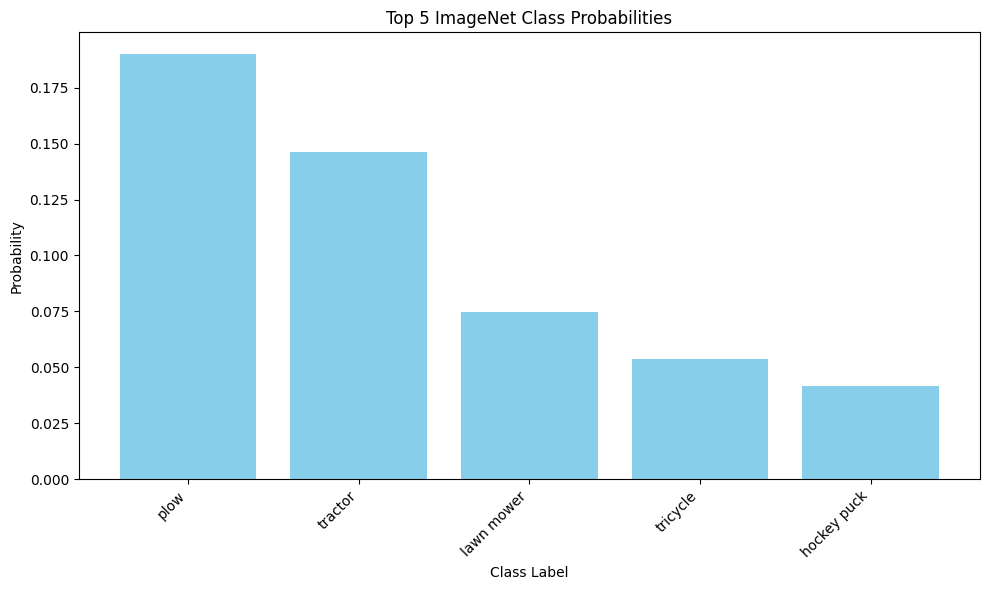

Classification complete.


In [38]:
 run_classification_pipeline(image_path="moto2.jpg")
